In [1]:
import jax

import jax.numpy as np
import jax.scipy as sp

import numpy as onp
from numpy.polynomial.hermite import hermgauss

import scipy as osp

from vb_lib import structure_model_lib, data_utils, plotting_utils
from vb_lib.preconditioner_lib import get_mfvb_cov_matmul
from bnpmodeling_runjingdev.sensitivity_lib import HyperparameterSensitivityLinearApproximation

import paragami

import time
from copy import deepcopy 

import matplotlib.pyplot as plt
%matplotlib inline  

from bnpmodeling_runjingdev import cluster_quantities_lib, modeling_lib


/accounts/grad/runjing_liu/.conda/envs/bnp_sensitivity_jax/lib/python3.8/site-packages/jax/lib/xla_bridge.py:130: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


# load data

In [2]:
data_file = '../../../../fastStructure/hgdp_data/huang2011_plink_files/' + \
                'phased_HGDP+India+Africa_2810SNPs-regions1to36.npz'

data = np.load(data_file)
g_obs = np.array(data['g_obs'], dtype = int)

In [3]:
n_obs = g_obs.shape[0]

In [4]:
data_file = '../data/huang2011_subsampled.npz'
data_subs = np.load(data_file)
g_obs_sub = np.array(data_subs['g_obs'], dtype = int)

indx_ind = data_subs['indx_ind']
indx_loci = data_subs['indx_loci']

In [5]:
assert np.all(g_obs_sub == g_obs[indx_ind][:, indx_loci])

# Load fit

In [6]:
filename = '../fits/f_sens_20201115/huang2011_sub_fit_alpha6.0.npz'

In [7]:
vb_opt_dict, vb_params_paragami, meta_data = \
    paragami.load_folded(filename)

vb_opt = vb_params_paragami.flatten(vb_opt_dict, free = True)

# logitnormal parameters
gh_deg = int(meta_data['gh_deg'])
gh_loc, gh_weights = hermgauss(gh_deg)

gh_loc = np.array(gh_loc)
gh_weights = np.array(gh_weights)

### Check KL

In [8]:
prior_params_dict, prior_params_paragami = \
    structure_model_lib.get_default_prior_params()

prior_params_dict['dp_prior_alpha'] = np.array(meta_data['dp_prior_alpha'])
prior_params_dict['allele_prior_alpha'] = np.array(meta_data['allele_prior_alpha'])
prior_params_dict['allele_prior_beta'] = np.array(meta_data['allele_prior_beta'])

In [9]:
kl = structure_model_lib.get_kl(g_obs_sub, vb_opt_dict, prior_params_dict,
                                    gh_loc, gh_weights)

In [10]:
kl - meta_data['final_kl']

DeviceArray(2.91038305e-11, dtype=float64)

# Plot fit

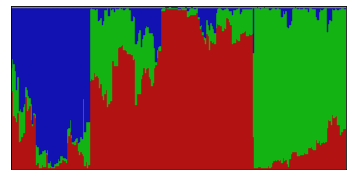

In [11]:
e_ind_admix = plotting_utils.get_vb_expectations(vb_opt_dict, gh_loc, gh_weights)[0]
# re-order individuals for better plotting
indx = data_utils.cluster_admix_get_indx(e_ind_admix)

f, axarr = plt.subplots(1, 1, figsize=(6, 3))
plotting_utils.plot_top_clusters(e_ind_admix[indx], axarr, 
                                               n_top_clusters = 3)

In [18]:
e_ind_admix.mean(0)[0:3].sum()

DeviceArray(0.99026626, dtype=float64)

# Define populations

In [12]:
input_file_str = '../../../../fastStructure/hgdp_data/HuangEtAl_2011-GenetEpi/' + \
                'phased_HGDP+India+Africa_2810SNPs-regions1to36.stru'

In [13]:
input_file = open(input_file_str, 'r') 

In [14]:
rs_number = input_file.readline().split()
region_number = input_file.readline().split()
chromosome_number = input_file.readline().split()
snp_position = input_file.readline().split()
core_region_indicator = input_file.readline().split()

In [15]:
individuals = [ line.split() for line in input_file.readlines() ]

In [16]:
len(individuals) == (n_obs * 2)

True

In [17]:
population_vec = []

for i in range(int(len(individuals) / 2)):
    row1 = individuals[2 * i]
    row2 = individuals[2 * i + 1]
    
    # all characteristics should be the same
    for j in range(6): 
        assert row1[j] == row2[j]
    
    population_vec.append(row1[4])
    
population_vec = onp.array(population_vec)

In [18]:
population_vec_sub = population_vec[indx_ind]

# Replot by population

In [31]:
pop_sort_indx = onp.argsort(population_vec_sub)

In [32]:
unique_groups = onp.sort(onp.unique(population_vec_sub))

In [33]:
unique_groups_cleaned = [pop_name.replace('_', ' ') for pop_name in unique_groups]

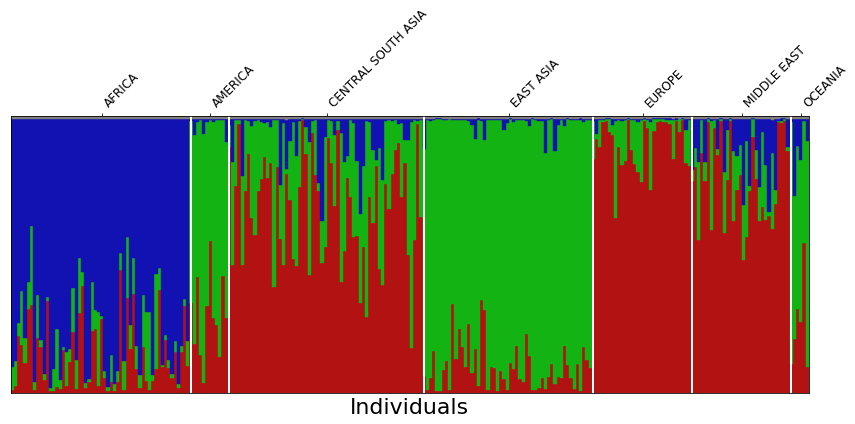

In [48]:
f, axarr = plt.subplots(1, 1, figsize=(12, 6))
plotting_utils.plot_top_clusters(e_ind_admix[pop_sort_indx], axarr, 
                                               n_top_clusters = 3);

# draw lines between different groups
xint = 0.
xticks = []
for i in range(len(unique_groups)): 
    incr = (population_vec_sub == unique_groups[i]).mean()
    
    xticks.append(xint + incr*0.5)
    xint += incr
    axarr.axvline(xint, color = 'white', linewidth = 2)
        
axarr.set_xticks(xticks)
axarr.set_xticklabels(unique_groups_cleaned,
                      rotation=45, ha='left', 
                      fontsize = 12);

axarr.xaxis.tick_top()


axarr.set_xlabel('Individuals', fontsize = 22)

f.tight_layout();